In [177]:
# 필요한 모듈 불러오기
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import torch
from time import sleep
import gridfs 
import io

# input : 이미촬영 -> 공유문서에 있는 이미지 가져온것
# =============================================================================================
# <파일 트랙킹 코드>
# 라즈베리파이 카메라로 사진을 획득한 과정이라고 생각
img = Image.open('../data/사전테스트데이터/test5.png')
# img = Image.open('/z/test4.png')
# plt.imshow(img)
# plt.show()
# =============================================================================================
# output : 이미지

def multi_objectDetection(img):
    img_color = np.array(img)
    img = np.array(img.convert('L'))

    # img_color_ROI = img_color[733:1437,710:1414]
    # img_ROI = img[733:1437,710:1414]
    img_color_ROI = img_color[300:1600,300:1600]
    img_ROI = img[300:1600,300:1600]


    # 데이터 이진화
    _, src_bin = cv2.threshold(img_ROI, 180, 255, cv2.THRESH_BINARY)
    src_bin = cv2.bitwise_not(src_bin)

    # 데이터 처리
    img_list = list()
    nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(src_bin)

    # print(stats)

    alpha = 2
    SIZE = 128
    for img_num in range(1,nlabels):
        stat = stats[img_num]
        x = stat[0] - alpha
        y = stat[1] - alpha
        width = stat[2] + 2*alpha
        height = stat[3] + 2*alpha
        n_pixel = stat[4]

        
        # 최대 픽셀 지정해서 임계값보다 크면 패스해버리기
        # if n_pixel < 500 or width > 64 or height > 64 : continue
        if n_pixel < 3000 : continue

        # cv2.rectangle(img_color_ROI, (x, y), (x+width, y+height), (0,100,255))
        
        # # 사각박스에 레이블 달아주기
        # text = str(img_num)
        # cv2.putText(img_color_ROI, text=text, org=(x+int(width/2), y), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 0, 0), thickness=2)
        
        
        delta_x = int((SIZE - width) / 2)
        delta_y = int((SIZE - height) / 2)
        # print(delta_x, delta_y)
        
        
        tmp1 = img_color_ROI[y : y+height, x : x+width, :].copy()
        tmp2 = np.zeros((SIZE,SIZE,3), dtype = int)
        
        # print(stat) # 가장자리쪽에 있는 생두들은 ROI를 벗어나는것들이 있다.
        try:
            for channel in range(3):
                tmp2[delta_y : delta_y + height, delta_x : delta_x + width , channel] = tmp1[0:height, 0:width, channel]
            tmp2 = np.uint8(tmp2)
            img_list.append((img_num, stat, tmp2))
        except:
            print(img_num, '에러다임마')

        
        # img_list.append((img_num, stat, tmp2))
    return img_list, img_color_ROI


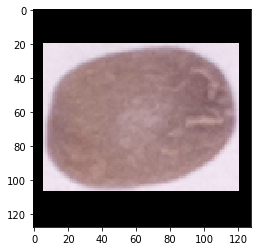

In [178]:
plt.imshow(multi_objectDetection(img)[0][5][2])

In [179]:
def imgPreprocessing(src, thres, SIZE):
    ############################################################################
    # <이미지 노이즈 및 배경 제거>

    # 그레이 스케일로 변환
    gray = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
    
    # 바이너리로 변환
    ret, binary = cv2.threshold(gray,thres,255, cv2.THRESH_BINARY)
    binary = cv2.bitwise_not(binary)

    # 바이너리 이미지와 원본 이미지의 데이터가 일치하는 부분 만 다시 추출히기
    tmp = np.zeros_like(src)
    for y in range(SIZE):
        for x in range(SIZE):
            if (binary != 0)[y,x]:
                for i in range(3):
                    tmp[y,x,i] = src[y,x,i]
    
    src_processed = tmp   

    # 이미지 크기 정의
    height = src_processed.shape[0]
    width = src_processed.shape[1]

    ############################################################################
    # <생두 무게 중심 구하기>
    R = list()
    for y in range(height):
        for x in range(width):
            if binary[y,x]:            
                R.append([y, x])

    # 질량의 합
    M = len(R)

    R = np.array(R)
    R_x = R[:,1]
    R_y = R[:,0]

    R_x_sum = R_x.sum()
    R_y_sum = R_y.sum()

    center = np.round(R_x_sum/M) , (np.round(R_y_sum/M))

    height_center = center[0]
    width_center = center[1]

    # print('center:', height_center, width_center)

 
    ############################################################################
    # <객체 외부의 노이즈 데이터 처리하기>

    # 바이너리의 윤곽선 추출
    _, contours, hierachy = cv2.findContours(binary, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)    
    
    # 생두 객체 윤곽과 윤곽벡터 구하기
    contours_leng = [len(i) for i in contours]
    contours_leng.sort()
    contours_leng = contours_leng[:-2]
    len_max = np.array(contours_leng).max()
    contour_vector = list()

    for i in contours:
        if len(i) == len_max:
            for point in i:
                contour_vector.append((point[0][1]-height_center, point[0][0]-width_center))
            
            # 윤곽 벡터 사이즈와 최대 사이즈 구하기
            vector_size = np.sqrt(np.array(contour_vector)[:,0]**2 + np.array(contour_vector)[:,1]**2 )
            max_size = vector_size.max()
    

    # 질량 벡터와 윤곽벡터를 비교하는 코드 짜기
    R_size = np.sqrt((R[:,1] - width_center) ** 2 + (R[:,0] - height_center) ** 2)
    R_total = np.hstack([R,R_size.reshape((R_size.shape[0],1))])

    # max_size 보다 큰 R 좌표들만 추출하기
    R_filtered = R_total[R_total[:,2] > max_size]


    # R_filtered의 좌표를 이용해서 노이즈 처리
    for i in R_filtered[:,:2]:
        src_processed[int(i[1]),int(i[0])] = 0

    ############################################################################
    # <이미지의 중심과 생두의 무게중심 일치시키기>
    
    # 1. 이미지 센터 좌표를 구한다 
    src_center = np.array([src_processed.shape[1] / 2, src_processed.shape[0] / 2])

    # 2. 객체의 중심을 구한다
    object_center = np.array([height_center, width_center])

    # 3. 이미지 중심과 객체의 중심의 차이를 구한다
    delta = object_center - src_center

    # 4. 이미지 이동
    height, width = src_processed.shape[:2]
    M = np.float32([[1, 0, -delta[0]], [0, 1, -delta[1]]]) # 이미지를 width 방향으로 delta[0]만큼 , hiehgt 방향으로 -delta[1]만큼
    img_translation = cv2.warpAffine(src_processed, M, (width,height))

    return src, binary, src_processed, img_translation, contours_leng


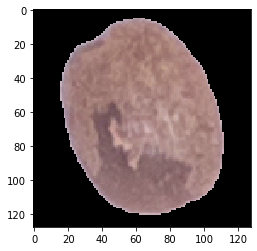

In [196]:
result = imgPreprocessing(multi_objectDetection(img)[0][1][2], 190, 128)[3]
plt.imshow(result)

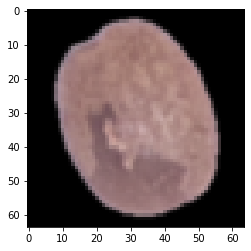

In [197]:
src = result
height, width, channel = src.shape
dst2 = cv2.pyrDown(src)
plt.imshow(dst2)